In [1]:
# ln -s ../code/analytic.py analytic.py
%matplotlib inline

import pandas
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as smtsa

import matplotlib.pyplot as pyplot

import thinkplot
import thinkstats2
import regression

In [2]:
transactions = pandas.read_csv('mj-clean.csv', parse_dates=[5])

In [3]:
transactions.describe()

,price,amount,ppg,lat,lon
count,147070.000000,147070.000000,147070.000000,146897.000000,146897.000000
mean,137.259516,15.336626,10.670560,37.858994,-91.988509
std,120.217590,11.145683,5.622977,5.008867,16.545298
min,4.000000,1.000000,1.020000,24.675731,-124.399110
25%,50.000000,5.000000,6.000000,33.990380,-104.804560
50%,100.000000,14.150000,10.600000,38.952526,-86.785248
75%,200.000000,28.300000,14.130000,41.598235,-79.107692
max,990.000000,28.300000,34.980000,49.054587,-67.086970


In [4]:
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [5]:
def GroupByQuality(transactions):
    groups = transactions.groupby('quality')
    dailies={}
    for name,group in groups:
        dailies[name] = GroupByDay(group)
    return dailies

def GroupByDay(transactions, func=np.mean):
    grouped = transactions[['date','ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year
    return daily

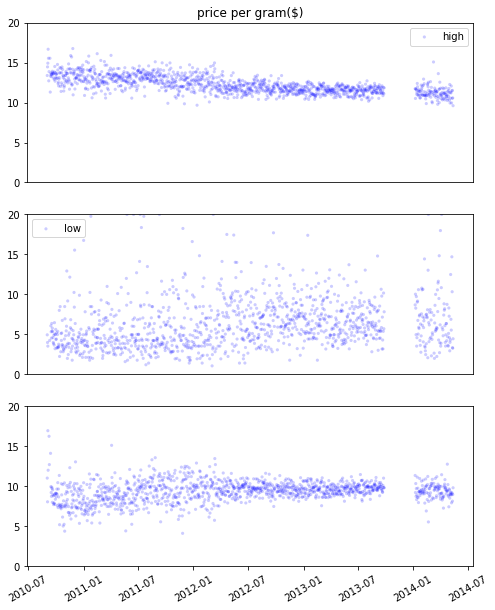

In [6]:
dailies = GroupByQuality(transactions)

thinkplot.PrePlot(rows=3)
for i, (name,daily) in enumerate(dailies.items()):
    thinkplot.SubPlot(i+1)
    title = 'price per gram($)' if i==0 else ''
    thinkplot.Config(ylim=[0,20], title=title)
    thinkplot.Scatter(daily.index, daily.ppg, s=10, label=name)
    if i==2:
        pyplot.xticks(rotation=30)
    else:
        thinkplot.Config(xticks=[])

In [7]:
def RunLinearModel(daily):
    model = smf.ols(formula = 'ppg ~ years', data=daily)
    results = model.fit()
    return model, results

def PlotFittedValues(model, results, label=''):
    years = model.exog[:,1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model')

for name, daily in dailies.items():
    model, results = RunLinearModel(daily)
    print(name)
    regression.SummarizeResults(results)

high
Intercept   13.4   (0)
years   -0.708   (3.69e-160)
R^2 0.4441
Std(ys) 1.096
Std(res) 0.8174
low
Intercept   5.36   (3.15e-130)
years   0.568   (2.76e-09)
R^2 0.0296
Std(ys) 3.381
Std(res) 3.332
medium
Intercept   8.88   (0)
years   0.283   (1.82e-15)
R^2 0.0499
Std(ys) 1.304
Std(res) 1.272


## Moving averages

Most series analysis is based on the modeling assumption that the observed series is the sum of three components:
* **Trend**: a smooth function that captures persistent changes.
* **Seasonality**: periodic variation, possibly including daily, weekly, monthly, or yearly cycles.
* **Noise**: random variation around the long-term trend.

Regression is one way to extract the trend from the series; a good alternative is a **moving average** into overlapping **windows**. One of the simplest moving averages is the **rolling mean**.

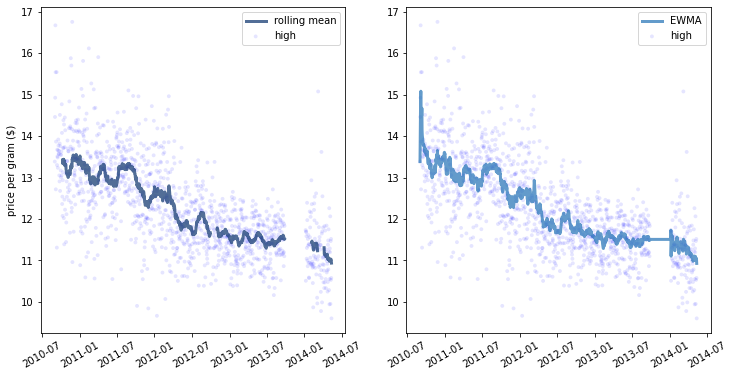

<Figure size 576x432 with 0 Axes>

In [31]:
# We reindex to deal with the missing data
dates = pandas.date_range(daily.index.min(), daily.index.max())
reindexed = dailies['high'].reindex(dates)
roll_mean = reindexed['ppg'].rolling(window=30).mean()

thinkplot.PrePlot(cols=2)
thinkplot.Scatter(reindexed.index, reindexed.ppg,
                  s=15, alpha=0.1, label='high')
thinkplot.Plot(roll_mean.index, roll_mean, label='rolling mean')
pyplot.xticks(rotation=30)
thinkplot.Config(ylabel='price per gram ($)')

thinkplot.SubPlot(2)
thinkplot.Scatter(reindexed.index, reindexed.ppg,
                  s=15, alpha=0.1, label='high')
ewma = reindexed['ppg'].ewm(span=30).mean()
thinkplot.Plot(reindexed.index, ewma, label='EWMA')
pyplot.xticks(rotation=30)
thinkplot.Show()

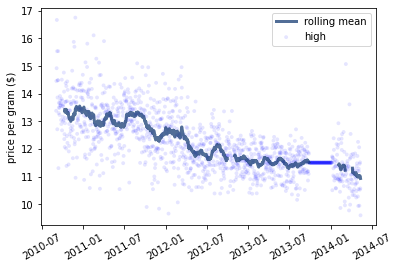

In [30]:
reindexed.ppg.fillna(ewma, inplace=True)
thinkplot.Scatter(reindexed.index, reindexed.ppg,
                  s=15, alpha=0.1, label='high')
thinkplot.Plot(roll_mean.index, roll_mean, label='rolling mean')
pyplot.xticks(rotation=30)
thinkplot.Config(ylabel='price per gram ($)')

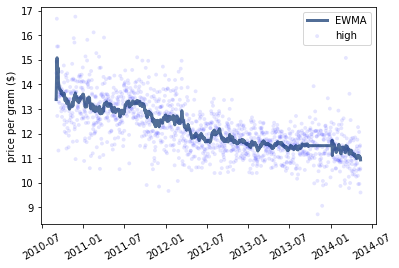

In [33]:
resid = (reindexed.ppg - ewma).dropna()
fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
reindexed.ppg.fillna(fake_data, inplace=True)
thinkplot.Scatter(reindexed.index, reindexed.ppg,
                  s=15, alpha=0.1, label='high')
thinkplot.Plot(reindexed.index, ewma, label='EWMA')
pyplot.xticks(rotation=30)
thinkplot.Config(ylabel='price per gram ($)')

## Serial correlation

In [34]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs,ys)
    return corr

SerialCorr(reindexed.ppg)

0.48547950327610767

In [36]:
resid=reindexed.ppg - ewma
SerialCorr(resid,1)

-0.006394279739746794

## Autocorrelation

In [38]:
acf = smtsa.acf(resid, nlags=365, unbiased=True)

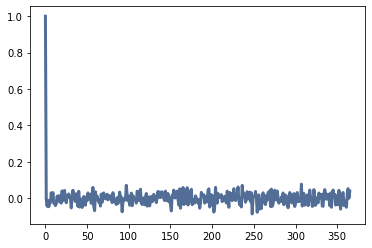

In [41]:
thinkplot.Plot(acf)